### Imports, splits stratifiés et paramètres globaux

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve,
    classification_report, average_precision_score
)
import matplotlib.pyplot as plt
import joblib

# Paramètres globaux
RANDOM_STATE = 42


Répartition des classes (total):
label
ham     4825
spam     747
Name: count, dtype: int64
Taille train/val/test: 3342 1115 1115


In [17]:
# Chargement
df = pd.read_csv("data/emails.csv")
df = df.dropna(subset=["text", "label"]).copy()
df["label_bin"] = (df["label"].str.lower() == "spam").astype(int)
X_all = df["text"].astype(str)
y_all = df["label_bin"].astype(int)


In [ ]:
# Split train/val/test (stratifié et reproductible)
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=RANDOM_STATE, stratify=y_all
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=RANDOM_STATE, stratify=y_trainval
)


In [19]:
print("Répartition des classes (total):")
print(df["label"].value_counts())
print("Taille train/val/test:", len(X_train), len(X_val), len(X_test))

Répartition des classes (total):
label
ham     4825
spam     747
Name: count, dtype: int64
Taille train/val/test: 3342 1115 1115


In [21]:
values = df['label'].value_counts()
total = values.sum()

percentage_0 = (values[0] /total) * 100
percentage_1 = (values[1]/ total) *100


/var/folders/3y/zx87b12j7j317bghrqxplm7h0000gn/T/ipykernel_16369/819895217.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  percentage_0 = (values[0] /total) * 100
/var/folders/3y/zx87b12j7j317bghrqxplm7h0000gn/T/ipykernel_16369/819895217.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  percentage_1 = (values[1]/ total) *100


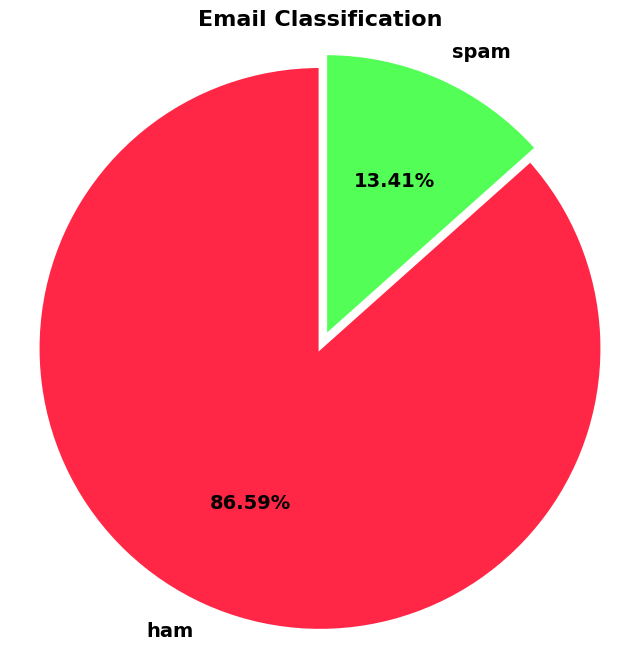

In [33]:
# Define custom colors
colors = ['#FF2745', '#53FF57']

# Define the explode parameter to create a gap between slices
explode = (0, 0.05)  # Explode the second slice (spam) by 10%

# Create a figure with a white background
fig, ax = plt.subplots(figsize=(8, 8))
ax.set_facecolor('white')

# Create the pie chart with custom colors, labels, explode parameter, and shadow
wedges, texts, autotexts = ax.pie(
    values, labels=['ham', 'spam'],
    autopct='%0.2f%%',
    startangle=90,
    colors=colors,
    wedgeprops={'linewidth': 2, 'edgecolor': 'white'},
    explode=explode,
)

for text, autotext in zip(texts, autotexts):
    text.set(size=14, weight='bold')
    autotext.set(size=14, weight='bold')

# Add a title
ax.set_title('Email Classification', fontsize=16, fontweight='bold')

ax.axis('equal')

plt.show()

### Entraînement: GridSearch multi‑modèles + sélection de seuil

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

candidates = {
    "LogReg": (
        LogisticRegression(max_iter=400, class_weight="balanced", random_state=RANDOM_STATE),
        {
            "tfidf__min_df": [2, 3],
            "tfidf__ngram_range": [(1,1), (1,2)],
            "clf__C": [0.5, 1.0, 2.0],
            "clf__penalty": ["l2"],
            "clf__solver": ["liblinear", "lbfgs"],
        },
    ),
    "LinearSVC": (
        CalibratedClassifierCV(
            estimator=LinearSVC(class_weight="balanced", random_state=RANDOM_STATE),
            cv=3
        ),
        {
            "tfidf__min_df": [2, 3],
            "tfidf__ngram_range": [(1,1), (1,2)],
        },
    ),
    "SVM_rbf": (
        SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=RANDOM_STATE),
        {
            "tfidf__min_df": [2],
            "tfidf__ngram_range": [(1,1), (1,2)],
            "clf__C": [0.5, 1.0],
            "clf__gamma": ["scale"],
        },
    ),
    "RandomForest": (
        RandomForestClassifier(class_weight="balanced", random_state=RANDOM_STATE),
        {
            "tfidf__min_df": [2],
            "tfidf__ngram_range": [(1,1)],
            "clf__n_estimators": [100, 200],
            "clf__max_depth": [None, 10],
        },
    ),
}


In [58]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)


In [60]:
grid_results = []
best_overall = None
best_name = None
best_ap = -np.inf

for name, (estimator, param_grid) in candidates.items():
    pipe = Pipeline([
        ("tfidf", TfidfVectorizer()),
        ("clf", estimator),
    ])
    grid = GridSearchCV(
        estimator=pipe,
        param_grid=param_grid,
        scoring="average_precision",
        cv=cv,
        n_jobs=-1,
        verbose=1,
        refit=True,
        return_train_score=False,
    )
    grid.fit(X_train, y_train)
    ap = grid.best_score_
    grid_results.append({"model": name, "best_ap": ap, "best_params": grid.best_params_})
    if ap > best_ap:
        best_ap = ap
        best_overall = grid.best_estimator_
        best_name = name

best_pipeline = best_overall
print("Meilleur modèle:", best_name)
print("Nombre de candidats évalués:", len(grid_results))

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Meilleur modèle: SVM_rbf
Nombre de candidats évalués: 4


In [61]:
# Sélection de seuil sur la validation pour maximiser F1
try:
    proba_val = best_pipeline.predict_proba(X_val)[:, 1]
except Exception:
    decision = best_pipeline.decision_function(X_val)
    d_min, d_max = decision.min(), decision.max()
    proba_val = (decision - d_min) / (d_max - d_min + 1e-9)

prec, rec, thr = precision_recall_curve(y_val, proba_val)
f1_vals = (2 * prec * rec) / (prec + rec + 1e-9)
opt_idx = int(np.nanargmax(f1_vals))
optimal_threshold = 0.5 if opt_idx >= len(thr) else thr[max(0, opt_idx - 1)]

print("Seuil optimal (val) pour F1:", float(optimal_threshold))

Seuil optimal (val) pour F1: 0.25832440335062923


In [62]:
# Évaluation validation
pred_val = (proba_val >= optimal_threshold).astype(int)
val_metrics = {
    "accuracy": float(accuracy_score(y_val, pred_val)),
    "precision": float(precision_score(y_val, pred_val, zero_division=0)),
    "recall": float(recall_score(y_val, pred_val, zero_division=0)),
    "f1": float(f1_score(y_val, pred_val, zero_division=0)),
    "average_precision": float(average_precision_score(y_val, proba_val)),
}
print("Validation metrics:", val_metrics)

Validation metrics: {'accuracy': 0.9847533632286996, 'precision': 0.965034965034965, 'recall': 0.92, 'f1': 0.9419795221843004, 'average_precision': 0.9745636170223603}


In [63]:
# Probas et prédictions test avec seuil sélectionné
try:
    y_proba_test = best_pipeline.predict_proba(X_test)[:, 1]
except Exception:
    decision_t = best_pipeline.decision_function(X_test)
    dmin, dmax = decision_t.min(), decision_t.max()
    y_proba_test = (decision_t - dmin) / (dmax - dmin + 1e-9)

# prédictions binaires avec seuil optimal
y_pred_test = (y_proba_test >= optimal_threshold).astype(int)

test_metrics = {
    "accuracy": float(accuracy_score(y_test, y_pred_test)),
    "precision": float(precision_score(y_test, y_pred_test, zero_division=0)),
    "recall": float(recall_score(y_test, y_pred_test, zero_division=0)),
    "f1": float(f1_score(y_test, y_pred_test, zero_division=0)),
    "roc_auc": float(roc_auc_score(y_test, y_proba_test)),
    "average_precision": float(average_precision_score(y_test, y_proba_test)),
}
print("Test metrics:", test_metrics)

Test metrics: {'accuracy': 0.9847533632286996, 'precision': 0.94, 'recall': 0.9463087248322147, 'f1': 0.9431438127090301, 'roc_auc': 0.9903045840454653, 'average_precision': 0.9764120018902145}


### Courbes ROC et Precision‑Recall (meilleur modèle)

[[957   9]
 [  8 141]]
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       966
        spam       0.94      0.95      0.94       149

    accuracy                           0.98      1115
   macro avg       0.97      0.97      0.97      1115
weighted avg       0.98      0.98      0.98      1115



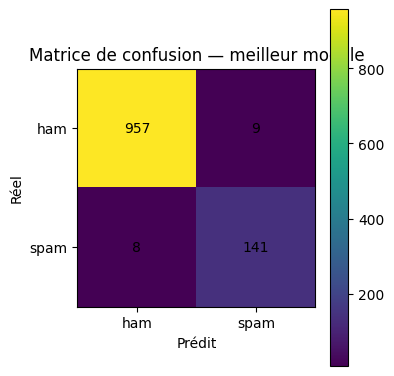

Faux positifs (ham→spam) : 9


In [64]:
cm = confusion_matrix(y_test, y_pred_test)
print(cm)
print(classification_report(y_test, y_pred_test, target_names=["ham","spam"]))

# Graphique : matrice de confusion
fig = plt.figure(figsize=(4,4))
plt.imshow(cm, interpolation='nearest')
plt.title('Matrice de confusion — meilleur modèle')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["ham","spam"])
plt.yticks(tick_marks, ["ham","spam"])
plt.xlabel('Prédit')
plt.ylabel('Réel')
for i in range(2):
    for j in range(2):
        plt.text(j, i, cm[i,j], ha='center', va='center')
plt.tight_layout()
plt.show()

fp = cm[0,1]
print(f"Faux positifs (ham→spam) : {fp}")

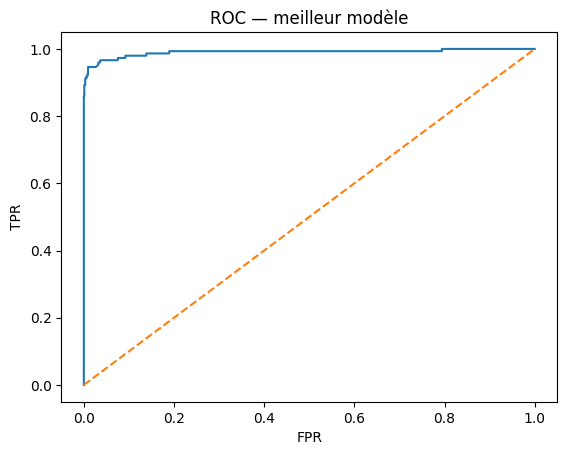

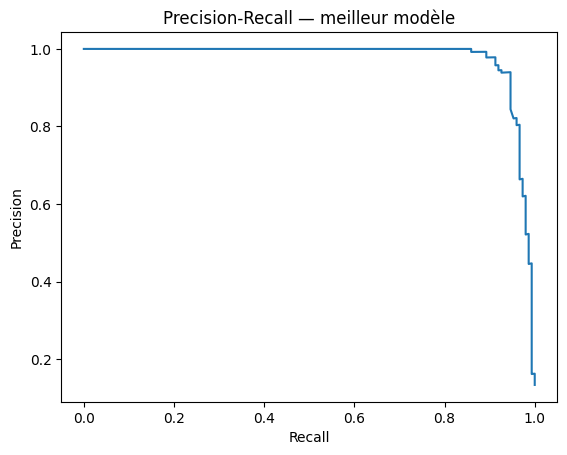

Seuil de décision utilisé: 0.25832440335062923


In [49]:
fpr, tpr, _ = roc_curve(y_test, y_proba_test)
fig = plt.figure()
plt.plot(fpr, tpr)
plt.plot([0,1],[0,1], linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC — meilleur modèle')
plt.show()

prec, rec, _ = precision_recall_curve(y_test, y_proba_test)
fig = plt.figure()
plt.plot(rec, prec)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision‑Recall — meilleur modèle')
plt.show()

print("Seuil de décision utilisé:", float(optimal_threshold))

### Résumé des scores (AP) du GridSearch

In [65]:
# Résumé des résultats GridSearch (AP sur CV)
import pandas as pd
if 'grid_results' in globals() and grid_results:
    display(pd.DataFrame(grid_results).sort_values(by="best_ap", ascending=False))
else:
    print("Exécutez la cellule de GridSearch d'abord.")

,model,best_ap,best_params
2,SVM_rbf,0.980756,"{'clf__C': 0.5, 'clf__gamma': 'scale', 'tfidf_..."
1,LinearSVC,0.979684,"{'tfidf__min_df': 2, 'tfidf__ngram_range': (1,..."
0,LogReg,0.978424,"{'clf__C': 2.0, 'clf__penalty': 'l2', 'clf__so..."
3,RandomForest,0.969741,"{'clf__max_depth': 10, 'clf__n_estimators': 20..."


### Cellule — Analyse d'erreurs (exemples mal classés)

In [66]:
# Identifier faux positifs et faux négatifs
pred_df = pd.DataFrame({
    "text": X_test.reset_index(drop=True),
    "y_true": y_test.reset_index(drop=True),
    "y_prob": y_proba_test,
    "y_pred": y_pred_test,
})

false_pos = pred_df[(pred_df.y_true == 0) & (pred_df.y_pred == 1)].sort_values("y_prob", ascending=False).head(10)
false_neg = pred_df[(pred_df.y_true == 1) & (pred_df.y_pred == 0)].sort_values("y_prob", ascending=True).head(10)

print("Top faux positifs (ham prédits spam):")
display(false_pos[["y_prob","text"]])
print("\nTop faux négatifs (spam prédits ham):")
display(false_neg[["y_prob","text"]])


Top faux positifs (ham prédits spam):


,y_prob,text
587,0.895558,Ok... Ur typical reply...
380,0.765317,K..u also dont msg or reply to his msg..
27,0.690154,Alright i have a new goal now
491,0.500000,Can u get pic msgs to your phone?
302,0.490476,Hi.:)technical support.providing assistance to...
931,0.446625,Please ask mummy to call father
705,0.388539,I got a call from a landline number. . . I am ...
1047,0.388539,I got a call from a landline number. . . I am ...
700,0.307641,We have sent JD for Customer Service cum Accou...



Top faux négatifs (spam prédits ham):


,y_prob,text
852,0.000690,"Do you realize that in about 40 years, we'll h..."
1069,0.006863,Hi ya babe x u 4goten bout me?' scammers getti...
841,0.010106,ROMCAPspam Everyone around should be respondin...
478,0.016563,For sale - arsenal dartboard. Good condition b...
219,0.021726,Sorry I missed your call let's talk when you h...
235,0.061604,"Latest News! Police station toilet stolen, cop..."
418,0.082319,Can U get 2 phone NOW? I wanna chat 2 set up m...
196,0.089857,ringtoneking 84484


### Cellule 6 — Graphiques comparatifs (ROC/PR)

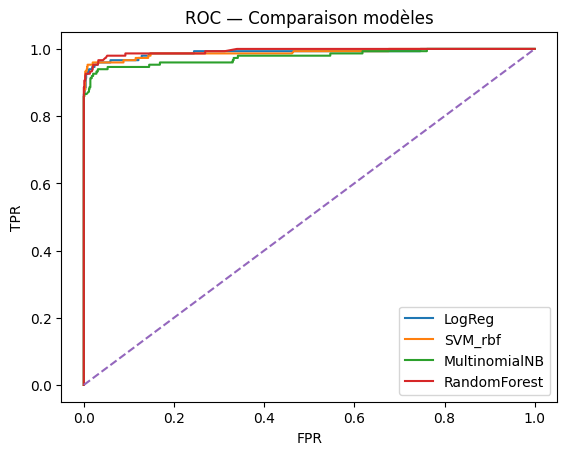

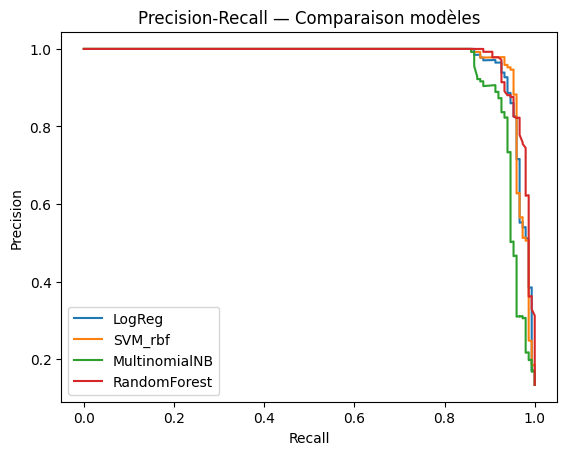

In [67]:
# ROC
if roc_curves:
    fig = plt.figure()
    for name, (fpr, tpr) in roc_curves.items():
        plt.plot(fpr, tpr, label=name)
    plt.plot([0,1],[0,1], linestyle='--')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC — Comparaison modèles')
    plt.legend()
    plt.show()

# PR
if pr_curves:
    fig = plt.figure()
    for name, (rec, prec) in pr_curves.items():
        plt.plot(rec, prec, label=name)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision‑Recall — Comparaison modèles')
    plt.legend()
    plt.show()

### Cellule 7 — Importance des features (LogReg)


In [68]:
# Top poids de la régression logistique
vec = best_pipeline.named_steps["tfidf"]
clf = best_pipeline.named_steps["clf"]
if hasattr(clf, "coef_"):
    terms = np.array(vec.get_feature_names_out())
    coefs = clf.coef_[0]
    top_spam_idx = np.argsort(coefs)[-20:][::-1]
    top_ham_idx = np.argsort(coefs)[:20]
    print("Top mots → spam:")
    print(list(zip(terms[top_spam_idx], coefs[top_spam_idx])))
    print("\nTop mots → ham:")
    print(list(zip(terms[top_ham_idx], coefs[top_ham_idx])))

### Cellule 8 — Sauvegarde du modèle baseline

In [69]:
Path("models").mkdir(parents=True, exist_ok=True)
joblib.dump(best_pipeline, "models/model.pkl")

# Sauvegarde du seuil optimal
with open("models/threshold.txt", "w") as f:
    f.write(str(float(optimal_threshold)))

print("Saved models/model.pkl et models/threshold.txt")

Saved models/model.pkl et models/threshold.txt


### Comparaison des modèles — tableau (AP CV) et bar chart


,model,best_ap,best_params
2,SVM_rbf,0.980756,"{'clf__C': 0.5, 'clf__gamma': 'scale', 'tfidf_..."
1,LinearSVC,0.979684,"{'tfidf__min_df': 2, 'tfidf__ngram_range': (1,..."
0,LogReg,0.978424,"{'clf__C': 2.0, 'clf__penalty': 'l2', 'clf__so..."
3,RandomForest,0.969741,"{'clf__max_depth': 10, 'clf__n_estimators': 20..."


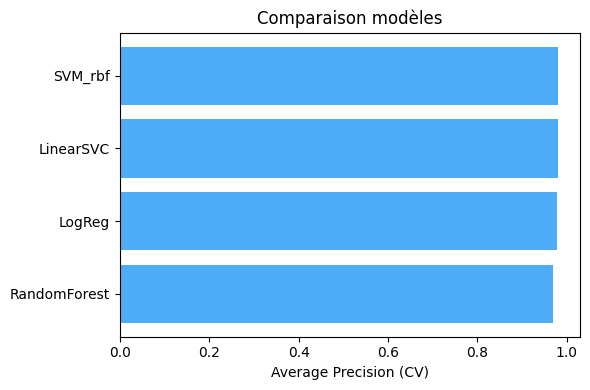

In [73]:
# Tableau comparatif (AP sur CV) + bar chart
import pandas as pd
import matplotlib.pyplot as plt

if 'grid_results' in globals() and grid_results:
    df_models = pd.DataFrame(grid_results).sort_values(by='best_ap', ascending=False)
    display(df_models)

    fig = plt.figure(figsize=(6,4))
    plt.barh(df_models['model'], df_models['best_ap'], color="#4dabf7")
    plt.gca().invert_yaxis()
    plt.xlabel('Average Precision (CV)')
    plt.title('Comparaison modèles')
    plt.tight_layout()
    plt.show()
else:
    print("Aucun résultat de GridSearch détecté. Exécutez la cellule d\'entraînement.")


### Comparaison des modèles — F1 test avec seuil optimal par modèle


,model,f1_test,threshold
1,LinearSVC,0.940351,0.607215
3,SVM_rbf,0.931973,0.518785
0,LogReg,0.928814,0.506963
2,MultinomialNB,0.906574,0.134051


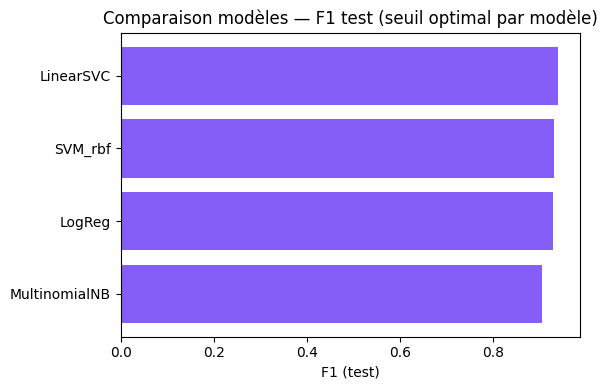

In [72]:
# Re-fit rapide par modèle et seuil optimal sur val, puis F1 sur test
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import precision_recall_curve, f1_score

candidates_eval = {
    "LogReg": LogisticRegression(max_iter=400, class_weight="balanced", random_state=RANDOM_STATE),
    "LinearSVC": CalibratedClassifierCV(estimator=LinearSVC(class_weight="balanced", random_state=RANDOM_STATE), cv=3),
    "MultinomialNB": MultinomialNB(),
    "SVM_rbf": SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=RANDOM_STATE),
}

rows = []
for name, est in candidates_eval.items():
    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(min_df=2, ngram_range=(1,2))),
        ("clf", est)
    ])
    pipe.fit(X_train, y_train)

    # seuil optimal sur val
    try:
        p_val = pipe.predict_proba(X_val)[:,1]
    except Exception:
        dec = pipe.decision_function(X_val)
        p_val = (dec - dec.min()) / (dec.max() - dec.min() + 1e-9)

    prec, rec, thr = precision_recall_curve(y_val, p_val)
    f1_vals = (2 * prec * rec) / (prec + rec + 1e-9)
    idx = int(np.nanargmax(f1_vals))
    th = 0.5 if idx >= len(thr) else thr[max(0, idx - 1)]

    # score test
    try:
        p_test = pipe.predict_proba(X_test)[:,1]
    except Exception:
        dec_t = pipe.decision_function(X_test)
        p_test = (dec_t - dec_t.min()) / (dec_t.max() - dec_t.min() + 1e-9)

    y_hat = (p_test >= th).astype(int)
    f1_t = f1_score(y_test, y_hat, zero_division=0)

    rows.append({"model": name, "f1_test": f1_t, "threshold": float(th)})

import pandas as pd
cmp_df = pd.DataFrame(rows).sort_values("f1_test", ascending=False)
display(cmp_df)

# bar chart
fig = plt.figure(figsize=(6,4))
plt.barh(cmp_df['model'], cmp_df['f1_test'], color="#845ef7")
plt.gca().invert_yaxis()
plt.xlabel('F1 (test)')
plt.title('Comparaison modèles — F1 test (seuil optimal par modèle)')
plt.tight_layout()
plt.show()
